# Debye scattering equation (2/2)
If all pair-wise distances are cast into a histogram, the scattering equation can be written:
$$ I \left( Q \right) = \left| f(Q) \right|^2  \left[ N + 2 \sum_{i=1}^{N_{bins}} n_i {sin \left(Q r_{i} \right) \over {Q r_{i}}}  \right] $$
where $n_i$ is the number of atomic pairs within the bin corresponding to a distance $r_i$.

Load external libraries.

In [1]:
import math
import numpy as np
import numexpr as ne
import numba as nb
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist
import os
n_cpu = os.cpu_count()
try:
    ref_intensity = np.loadtxt("ref_intensity.txt")
except :
    print("No reference intensity file found. An error will occur when evaluating the relative error in the computed intensities.")

Now we load the atomic coordinates and the coefficients required for the calculation of the atomic scattering factor. The first 11 elements of the coeff array are the coefficients given by [Waasmaier & Kirfel](https://doi.org/10.1107/S0108767394013292) for each element of the periodic table. The last element is the absorption/anomalous dispersion coefficient as given in the [Brennan-Cowan database](https://doi.org/10.1063/1.1142625).

In [2]:
# Atomic coordinates within cluster
coords = np.loadtxt("Au.xyz")
# Atomic scattering factor coefficients
coeff = np.array([16.777390,19.317156,32.979683,5.595453,10.576854,-6.279078,0.122737,
                  8.621570,1.256902,38.008820,0.000601, -4.014837862516359+7.717066375953113j])
# Define 2theta computation range
tth = np.arange(10, 180, 0.2)*np.pi/180
# X-ray wavelength
wl = 1.5406
# Step (in Angstroms) to compute the distance histogram
step=0.0005

Global variables computed from the above

In [3]:
N, dim = np.shape(coords) #Extract the number of atoms and the number of dimensions
Q = 4*np.pi*np.sin(tth/2) / wl #Compute the scatttering vector range
intensity_pt = np.loadtxt("ref_intensity.txt")

# Part 1: computing pairwise distances

## Cython implementation

In [4]:
%load_ext Cython

In [5]:
%%cython --compile-args=-fopenmp --link-args=-fopenmp
import numpy as np
from cython.parallel import prange
import cython

cimport numpy as cnp
from libc.math cimport sqrt

@cython.wraparound(False)
@cython.boundscheck(False)
@cython.cdivision(True)
def r_ij_cython(double[:,::1] coords):
    cdef:
        double[::1] r
        double tmp
        cnp.int64_t i,j,k,l
        cnp.int64_t N = coords.shape[0]
        cnp.int64_t dim = coords.shape[1]
    
    r = np.zeros(int((N*N-N)/2), dtype=np.float64)
    for i in prange(N, nogil=True):
        for j in range(i+1,N):
            l = int(i * (N - 1) - i * (i + 1) / 2 + j - 1)
            tmp = 0.0
            for k in range(dim):
                tmp = tmp + (coords[i,k]-coords[j,k])**2
            r[l] = sqrt(tmp)
    return r

In [6]:
%timeit r_ij_cython(coords)
r_ij_ct = np.asarray(r_ij_cython(coords))
bins=np.arange(r_ij_ct.min(), r_ij_ct.max()+step, step)

100 loops, best of 3: 13 ms per loop


# Part 2: compute the distance histogram

Numpy has a built-in function to evaluate a histogram from a given data set. The result of this evaluation will be used to check the validity of our calculations.

In [7]:
%timeit np.histogram(r_ij_ct, bins)[0]
Nr_sp = np.histogram(r_ij_ct, bins)[0]

1 loop, best of 3: 781 ms per loop


Compute the histogram from the pairwise distance distribution: serial algorithm

In [8]:
%%cython --compile-args=-fopenmp --link-args=-fopenmp
import numpy as np
import cython

cimport numpy as cnp

@cython.wraparound(False)
@cython.boundscheck(False)
@cython.cdivision(True)
def hist_cython(double[::1] data, double[::1] bins):
    cdef:
        double[::1] hist
        double max_bins, min_bins
        cnp.int64_t i, data_size, hist_size, index
        
    data_size = data.size
    hist_size = bins.size
    max_bins = max(bins)
    min_bins = min(bins)
    hist = np.zeros(hist_size-1)
    step = (max_bins-min_bins)/(hist_size-1)
        
    for i in range(data_size):
        index = int((data[i]-min_bins)/step)
        hist[index] = hist[index] + 1
    return hist

In [9]:
Nr_ct = hist_cython(r_ij_ct, bins)
%timeit hist_cython(r_ij_ct, bins)
print("Is the result correct:",np.allclose(Nr_ct, Nr_sp))

10 loops, best of 3: 50.1 ms per loop
Is the result correct: True


Parallel algorithm: in order to avoid the different threads to write at the same moment in the same memory block, each thread owns a copy of the histogram. All copies are summed up in the end.

In [10]:
%%cython --compile-args=-fopenmp --link-args=-fopenmp
import numpy as np
from cython.parallel import prange, threadid
import cython

cimport numpy as cnp

@cython.wraparound(False)
@cython.boundscheck(False)
@cython.cdivision(True)
def hist_cython_p(double[::1] data, double[::1] bins, int threads):
    cdef:
        double[::1] hist
        double[:,::1] hist_ar
        double max_bins, min_bins
        cnp.int64_t i, j, data_size, hist_size, index
        
    data_size = data.size
    hist_size = bins.size-1
    max_bins = max(bins)
    min_bins = min(bins)
    hist = np.zeros(hist_size)
    hist_ar = np.zeros((threads,hist_size))
    step = (max_bins-min_bins)/(hist_size)
        
    for i in prange(data_size, nogil=True, num_threads = threads):
        index = int((data[i]-min_bins)/step)
        hist_ar[threadid(), index] = hist_ar[threadid(),index] + 1 
    
    for i in range(threads):
        for j in range(hist_size):
            hist[j] = hist[j] + hist_ar[i,j]
    
    return hist

In [11]:
Nr_ctp = hist_cython_p(r_ij_ct, bins, n_cpu)
%timeit hist_cython_p(r_ij_ct, bins, n_cpu)
print("Is the result correct:",np.allclose(Nr_ctp, Nr_sp))

10 loops, best of 3: 68.6 ms per loop
Is the result correct: True


# Part 3: perform the summation over $r_{ij}$

First compute the atomic scattering factor

In [12]:
def asf(th,wl,coeff):
    n = 0
    sum = coeff[5]
    while n <= 4:
        sum = sum + coeff[n] * np.exp ( -coeff[n+6] * ( np.sin(th) / wl )**2)
        n = n+1
    return sum + coeff[-1]
f_at = asf(tth/2, wl, coeff)

Finally, compute the intensity using the histogram.

In [13]:
%%cython --compile-args=-fopenmp --link-args=-fopenmp
import numpy as np
import math
from cython.parallel import prange
import cython

cdef extern from "math.h" nogil:
    double sin(double x)
    
cdef extern from "complex.h" nogil:
    double cabs(double complex)

@cython.wraparound(False)
@cython.boundscheck(False)
@cython.cdivision(True)
def Debye_cython_hist(double[::1] Q, double[::1] r, double[::1] w,
                 long N, double complex[::1] f_at):
    cdef:
        double tmp
        long i_r, i_Q, size_r, size_Q
        double[::1] res
    
    size_r = r.size
    size_Q = Q.size
    res = np.zeros((size_Q))
    for i_Q in prange(size_Q, nogil=True):
        tmp = 0.0
        for i_r in range(size_r):
            tmp = tmp + w[i_r]*sin(Q[i_Q]*r[i_r])/(Q[i_Q]*r[i_r])
        res[i_Q] = (N + 2*tmp)*cabs(f_at[i_Q])**2
    return res

In [14]:
bins=bins[:-1:]
%timeit Debye_cython_hist(Q, bins, Nr_ctp, N,f_at)
intensity_ct_hist = Debye_cython_hist(Q, bins,Nr_ctp, N,f_at)
print("Error:", abs(intensity_ct_hist-ref_intensity).max()/ref_intensity.max())

10 loops, best of 3: 45.4 ms per loop
Error: 0.000847234163537


<IPython.core.display.Javascript object>


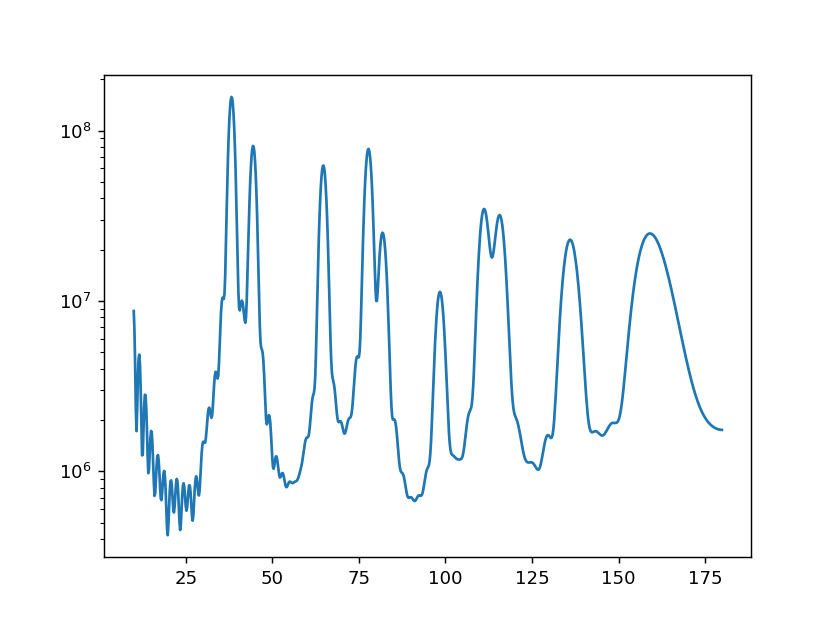

In [15]:
%matplotlib notebook
plt.semilogy(tth*180/np.pi, intensity_ct_hist)
plt.show()